In [ ]:
# imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

In [5]:
# local imports
from utility import get_memory_usage_and_runtime, auc_roc_curves, create_confusion_matrix
from data_preprocessing import  get_dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Define the all_data path (created in data_preprocessing python file)
data_path = '/data/all_data.npz'

# Data Preprocessing

In [6]:
def convert_to_tensors_and_get_data_loaders(data):
  '''
  For each traing, validation and test set, convert the numpy arrays to torch tensors and create dataloaders for train and validation sets.

  :@param data (list): List of x_train, x_val, x_test, y_train, y_val, y_test
  :@return train_loader, valid_loader (DataLoader): pytorch class
  :@return x_test, y_test torch tensors
  '''

  x_train_np, x_valid_np, x_test_np, y_train_np, y_valid_np, y_test_np = data

  x_train = torch.tensor(x_train_np, dtype=torch.float32).unsqueeze(1).to(device)
  x_test = torch.tensor(x_test_np, dtype=torch.float32).unsqueeze(1).to(device)
  x_valid = torch.tensor(x_valid_np, dtype=torch.float32).unsqueeze(1).to(device)

  y_train =  torch.tensor(y_train_np, dtype=torch.long).to(device)
  y_test =   torch.tensor(y_test_np, dtype=torch.long).to(device)
  y_valid =  torch.tensor(y_valid_np, dtype=torch.long).to(device)

  # create train loader and validation loader
  dataset_train = TensorDataset(x_train, y_train)
  train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)

  dataset_valid = TensorDataset(x_valid, y_valid)
  valid_loader = DataLoader(dataset_valid, batch_size=32, shuffle=True)

  return train_loader, valid_loader, x_test, y_test

In [ ]:
# Original Data
train_loader_o, valid_loader_o, x_test_o, y_test_o = convert_to_tensors_and_get_data_loaders(get_dataset(use_external=False, aug_data=False))

# Original Data + Augmented Data to Train
train_loader_a, valid_loader_a, x_test_a, y_test_a = convert_to_tensors_and_get_data_loaders(get_dataset(use_external=False, aug_data=True))

# Original Data + Augmented Data to Train + External Datasets to Train
train_loader_d, valid_loader_d, x_test_d, y_test_d = convert_to_tensors_and_get_data_loaders(get_dataset(use_external=True, aug_data=True))

# Define CNN

In [7]:
class LiverCNN(nn.Module):
    def __init__(self, imgsize, return_attention=True):
      super(LiverCNN, self).__init__()

      # convolutional layers
      self.conv1 = nn.Conv2d(1, 12, kernel_size=3, padding=1)
      self.conv2 = nn.Conv2d(12, 24, kernel_size=3, padding=1)

      # pool fetaures together
      self.pool = nn.MaxPool2d(2, 2)

      # use dropout layer to delete 20% of features to prevent overfitting
      self.drop = nn.Dropout2d(p=0.3)

      # define attention layer
      self.return_attention = return_attention

      self.attention = nn.Sequential(
          nn.Conv2d(24, 1, kernel_size=1),  # attention mechanism applied to feature maps
          nn.Sigmoid()
      )

      # define fully connected layer for output
      # image is pooled twice with 2x2 kernel -> = imgsize/4 x imgsize/4 image
      # convolution layer generates 24 patches, so x 24
      self.out_layer_size = int(imgsize/4 * imgsize/4 * 24)
      self.fc1 = nn.Linear(self.out_layer_size, imgsize)
      self.fc2 = nn.Linear(imgsize, 2)

    def forward(self, x):

      # apply comvolutional layers with relu and pooling
      x = F.relu(self.pool(self.conv1(x)))
      x = F.relu(self.pool(self.conv2(x)))

      # attention mechanism
      attention_weights = self.attention(x)
      x = x * attention_weights  # apply attention to feature maps

      # drop training data to prevent overfitting
      x = F.dropout(self.drop(x), training=self.training)

      # flatten to prepare for fully connected layers
      x = x.reshape(-1, self.out_layer_size)

      # fully connected layers (the first with relu)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)

      if self.return_attention:
          return x, attention_weights
      else:
          return x

# Training CNN

In [8]:
def train(model, loss_fn, optimizer, epochs, train_loader, valid_loader):
  accuracies_train = []
  losses_train = []
  accuracies_valid = []
  losses_valid = []

  for epoch in range(epochs):
    # store predictions and labels for train/validation sets
    predictions_train = []
    labels_train = []
    predictions_valid = []
    labels_valid = []

    # ------- STAGE 1: TRAINING ----------
    model.train()
    train_loss = 0

    for images, labels in train_loader:

      #zero the gradients
      optimizer.zero_grad()

      # get predictions
      outputs = model(images)

      #calculate loss/gradients
      if isinstance(outputs, tuple):
          predictions, attention_weights = outputs
          loss = loss_fn(predictions, labels)
      else:
          predictions = outputs
          loss = loss_fn(outputs, labels)
      loss.backward()

      #adjust rates
      optimizer.step()

      # store predictions, labels, and loss
      predictions_train.extend(torch.argmax(predictions, dim=1).tolist())
      labels_train.extend(labels.tolist())
      train_loss += loss.item()

    # calculate train accuracy and average loss for this epoch
    accuracy_train = torch.sum(torch.tensor(predictions_train) == torch.tensor(labels_train)).item() / len(labels_train)
    avg_train_loss = train_loss / len(train_loader)
    accuracies_train.append(accuracy_train)
    losses_train.append(avg_train_loss)

    # ------- STAGE 2: VALIDATION ----------
    model.eval()
    valid_loss = 0

    with torch.no_grad():
        for images, labels in valid_loader:

          # get predictions
          outputs = model(images)

          # calculate loss
          if isinstance(outputs, tuple):
              predictions, attention_weights = outputs
              loss = loss_fn(predictions, labels)
          else:
              predictions = outputs
              loss = loss_fn(outputs, labels)

          # store predictions, labels, and loss
          predictions_valid.extend(torch.argmax(predictions, dim=1).tolist())
          labels_valid.extend(labels.tolist())
          valid_loss += loss.item()

    # calculate validation accuracy and average loss for this epoch
    accuracy_valid = torch.sum(torch.tensor(predictions_valid) == torch.tensor(labels_valid)).item() / len(labels_valid)
    avg_valid_loss = valid_loss / len(valid_loader)
    accuracies_valid.append(accuracy_valid)
    losses_valid.append(avg_valid_loss)

    print("Epoch", epoch+1, "Training Accuracy", accuracy_train, "Training Loss", avg_train_loss, "Validation Accuracy", accuracy_valid, "Validation Loss", avg_valid_loss)

  return accuracies_train, losses_train, accuracies_valid, losses_valid

def train_and_val_loss_accuracy_plots(EPOCHS, losses_train, losses_valid, accuracies_train, accuracies_valid):
  '''
  Plots train and validation loss and accuracies side by side

  :@param EPOCHS (int): number of epochs
  :@param losses_train (list): Training set losses
  :@param losses_valid (list): Validation set losses
  :@param accuracies_train (list): Training set accuracies
  :@param accuracies_valid (list): Validation set accuracies
  '''
  plt.figure(figsize=(12, 4))

  plt.subplot(1, 2, 1)
  plt.plot(range(1, EPOCHS+1), losses_train, label='Train Loss')
  plt.plot(range(1, EPOCHS+1), losses_valid, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title("Training and Validation Losses for Liver CNN")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(range(1, EPOCHS+1), accuracies_train, label='Train Accuracy')
  plt.plot(range(1, EPOCHS+1), accuracies_valid, label='Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title("Training and Validation Accuracies for Liver CNN")
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
# hyperparamters
LR = 0.0001
EPOCHS = 15
imgsize = 128
weight_decay = 1

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 128, 128]             120
         MaxPool2d-2           [-1, 12, 64, 64]               0
            Conv2d-3           [-1, 24, 64, 64]           2,616
         MaxPool2d-4           [-1, 24, 32, 32]               0
            Conv2d-5            [-1, 1, 32, 32]              25
           Sigmoid-6            [-1, 1, 32, 32]               0
         Dropout2d-7           [-1, 24, 32, 32]               0
            Linear-8                  [-1, 128]       3,145,856
            Linear-9                    [-1, 2]             258
Total params: 3,148,875
Trainable params: 3,148,875
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 3.02
Params size (MB): 12.01
Estimated Total Size (MB): 15.09
-------------------------------------

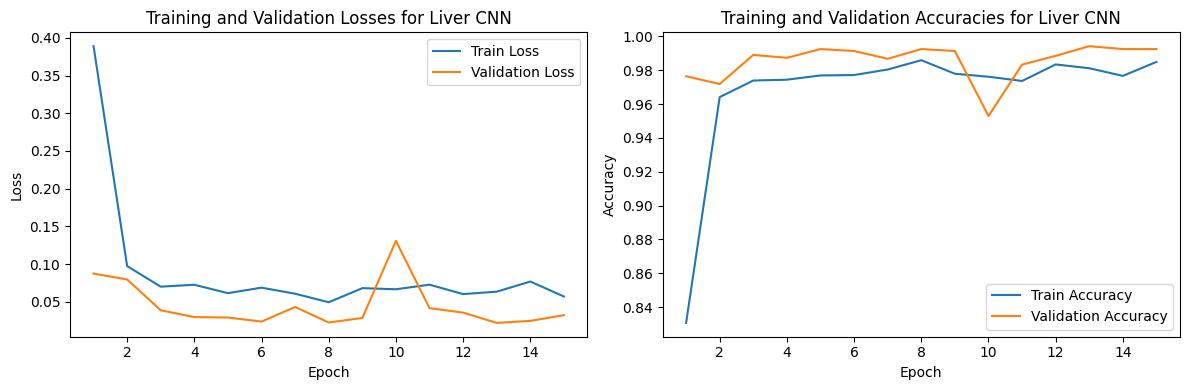

In [ ]:
# Train Original and save
model_o = LiverCNN(imgsize=imgsize).to(device)
loss_fn_o = nn.CrossEntropyLoss()
optimizer_o = optim.Adam(model_o.parameters(), lr=LR, weight_decay=weight_decay)

# show summary of model network
from torchsummary import summary
summary(model_o, input_size=(1, 128, 128))

accuracies_train_o, losses_train_o, accuracies_valid_o, losses_valid_o = train(model_o, loss_fn_o, optimizer_o, EPOCHS, train_loader_o, valid_loader_o)
train_and_val_loss_accuracy_plots(EPOCHS, losses_train_o, losses_valid_o, accuracies_train_o, accuracies_valid_o)
torch.save(model_o.state_dict(), 'cnn_model_original_data.pth')

Epoch 1 Training Accuracy 0.8771471514457486 Training Loss 0.3097867661622487 Validation Accuracy 0.9753440366972477 Validation Loss 0.08781276416372169
Epoch 2 Training Accuracy 0.9206627540795878 Training Loss 0.2045207349476948 Validation Accuracy 0.9879587155963303 Validation Loss 0.057459648326039316
Epoch 3 Training Accuracy 0.9199112510735757 Training Loss 0.2082242421524544 Validation Accuracy 0.9317660550458715 Validation Loss 0.16104776574806734
Epoch 4 Training Accuracy 0.913756083595763 Training Loss 0.21589677362730492 Validation Accuracy 0.9827981651376146 Validation Loss 0.06806583540006117
Epoch 5 Training Accuracy 0.909783853421128 Training Loss 0.23024598411891772 Validation Accuracy 0.9873853211009175 Validation Loss 0.07465484298088333
Epoch 6 Training Accuracy 0.9106784998568566 Training Loss 0.22746186945544772 Validation Accuracy 0.9908256880733946 Validation Loss 0.06259206066077405
Epoch 7 Training Accuracy 0.9089249928428285 Training Loss 0.22824642289796465 V

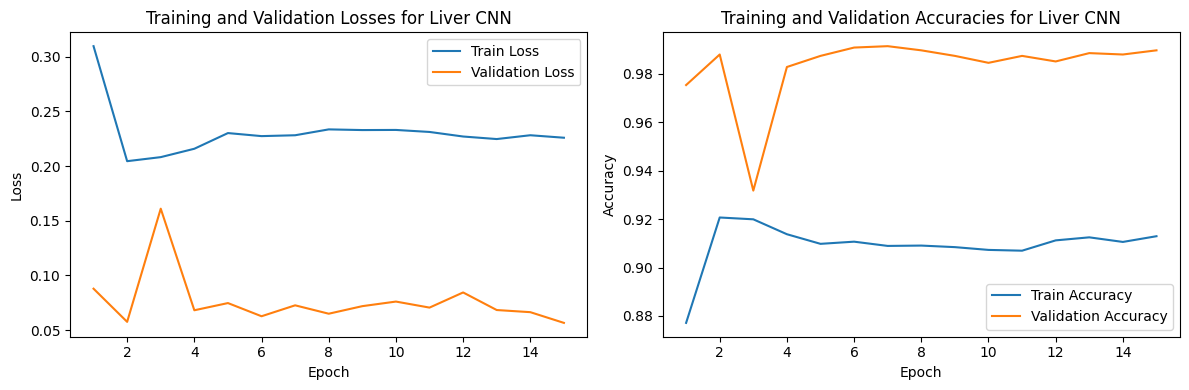

In [ ]:
# Train Original + Augmented and save
model_a = LiverCNN(imgsize=imgsize).to(device)
loss_fn_a = nn.CrossEntropyLoss()
optimizer_a = optim.Adam(model_a.parameters(), lr=LR, weight_decay=weight_decay)

accuracies_train_a, losses_train_a, accuracies_valid_a, losses_valid_a = train(model_a, loss_fn_a, optimizer_a, EPOCHS, train_loader_a, valid_loader_a)
train_and_val_loss_accuracy_plots(EPOCHS, losses_train_a, losses_valid_a, accuracies_train_a, accuracies_valid_a)
torch.save(model_a.state_dict(), 'cnn_model_original_plus_augmented_data.pth')

Epoch 1 Training Accuracy 0.8860613071139387 Training Loss 0.25955096357288937 Validation Accuracy 0.981651376146789 Validation Loss 0.0787686543369835
Epoch 2 Training Accuracy 0.9302304343855591 Training Loss 0.1892327891650021 Validation Accuracy 0.9913990825688074 Validation Loss 0.062407063794406976
Epoch 3 Training Accuracy 0.9282822440717178 Training Loss 0.19311330583175063 Validation Accuracy 0.9942660550458715 Validation Loss 0.052289458635178476
Epoch 4 Training Accuracy 0.9281300417034489 Training Loss 0.19370183783937917 Validation Accuracy 0.992545871559633 Validation Loss 0.08563719750805335
Epoch 5 Training Accuracy 0.9300782320172902 Training Loss 0.1899950408395797 Validation Accuracy 0.9764908256880734 Validation Loss 0.11389728926799514
Epoch 6 Training Accuracy 0.9323917080149767 Training Loss 0.1860092368154644 Validation Accuracy 0.9954128440366973 Validation Loss 0.04295854344964027
Epoch 7 Training Accuracy 0.9337310888557426 Training Loss 0.18438440899001007 V

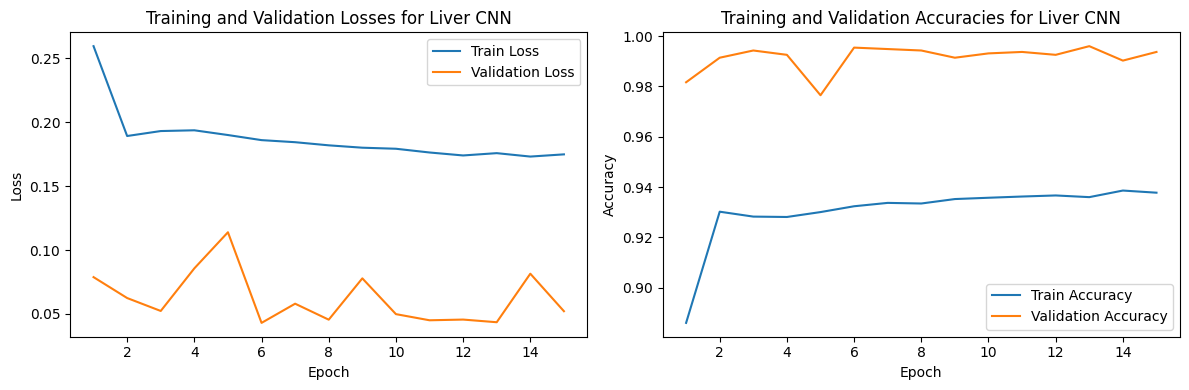

In [ ]:
# Train Original + Augmented + External and save
model_d = LiverCNN(imgsize=imgsize).to(device)
loss_fn_d = nn.CrossEntropyLoss()
optimizer_d = optim.Adam(model_d.parameters(), lr=LR, weight_decay=weight_decay)

accuracies_train_d, losses_train_d, accuracies_valid_d, losses_valid_d = train(model_d, loss_fn_d, optimizer_d, EPOCHS, train_loader_d, valid_loader_d)
train_and_val_loss_accuracy_plots(EPOCHS, losses_train_d, losses_valid_d, accuracies_train_d, accuracies_valid_d)
torch.save(model_d.state_dict(), 'cnn_model_original_plus_augmented_plus_external_data.pth')

# Attention Maps

In [9]:
def get_test_outputs_with_attention(x_test, model):
    '''
    Get test outputs, and the attention layer outputs.

    :@param x_test: Test set images
    :@param model: CNN model
    :@return outputs, torch vector
    '''
    model.eval()
    with torch.no_grad():
        outputs = model(x_test)

        if isinstance(outputs, tuple) and len(outputs) > 1:
            attention_weights = outputs[1]
        else:
            print("No attention weights")

    return outputs

def calculate_attention_maps(x_test, model):
    '''
    Returns numpy attention maps from model

    :@param x_test: Test set images
    :@param model: CNN model
    :@return attention_maps (numpy array)
    '''
    attention_maps = []
    _, attention_weights = get_test_outputs_with_attention(x_test, model)

    if attention_weights is not None:
        attention_maps = attention_weights.squeeze(1).cpu().numpy()  # squeeze to remove channel dimension

    return attention_maps

def visualize_attention_maps_for_sample(attention_map, original_image, dpi=100):
    '''
    Plots the attention map side by side with the sample image

    :@param attention_map (numpy array)
    :@param original_image (numpy array)
    :@param dpi (dots per inch) - resolution
    '''
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=dpi)

    # plot original image
    axes[0].imshow(original_image.squeeze().cpu(), cmap='gray')  # transfer image tensor to CPU
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # plot attention map
    im = axes[1].imshow(original_image.squeeze().cpu(), cmap='gray')  # transfer image tensor to CPU
    im2 = axes[1].imshow(attention_map, cmap='jet', alpha=0.6)  # overlay attention map
    axes[1].axis('off')
    axes[1].set_title('Attention Map')

    # add legend
    cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # x, y, width, height
    cbar = fig.colorbar(im2, cax=cbar_ax)
    cbar.set_label('Attention Intensity')

    plt.tight_layout()
    plt.show()

In [ ]:
# get test outputs for different datasets
outputs_o, attention_weights_o = get_test_outputs_with_attention(x_test_o, model_o)
outputs_a, attention_weights_a = get_test_outputs_with_attention(x_test_a, model_a)
outputs_d, attention_weights_d = get_test_outputs_with_attention(x_test_d, model_d)

attention_maps_o = calculate_attention_maps(x_test_o, model_o)
attention_maps_a = calculate_attention_maps(x_test_a, model_a)
attention_maps_d = calculate_attention_maps(x_test_d, model_d)

In [ ]:
# Print shapes of outputs and attention weights (if available)
print("Shapes - Outputs and Attention Weights:")
print("Outputs O:", outputs_o.shape if isinstance(outputs_o, torch.Tensor) else "No outputs")
print("Attention Weights O:", attention_weights_o.shape if isinstance(attention_weights_o, torch.Tensor) else "No attention weights")
print("Outputs A:", outputs_a.shape if isinstance(outputs_a, torch.Tensor) else "No outputs")
print("Attention Weights A:", attention_weights_a.shape if isinstance(attention_weights_a, torch.Tensor) else "No attention weights")
print("Outputs D:", outputs_d.shape if isinstance(outputs_d, torch.Tensor) else "No outputs")
print("Attention Weights D:", attention_weights_d.shape if isinstance(attention_weights_d, torch.Tensor) else "No attention weights")

Shapes - Outputs and Attention Weights:
Outputs O: torch.Size([1240, 2])
Attention Weights O: torch.Size([1240, 1, 32, 32])
Outputs A: torch.Size([1240, 2])
Attention Weights A: torch.Size([1240, 1, 32, 32])
Outputs D: torch.Size([1240, 2])
Attention Weights D: torch.Size([1240, 1, 32, 32])


<ipython-input-44-0f89a4472d1c>:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


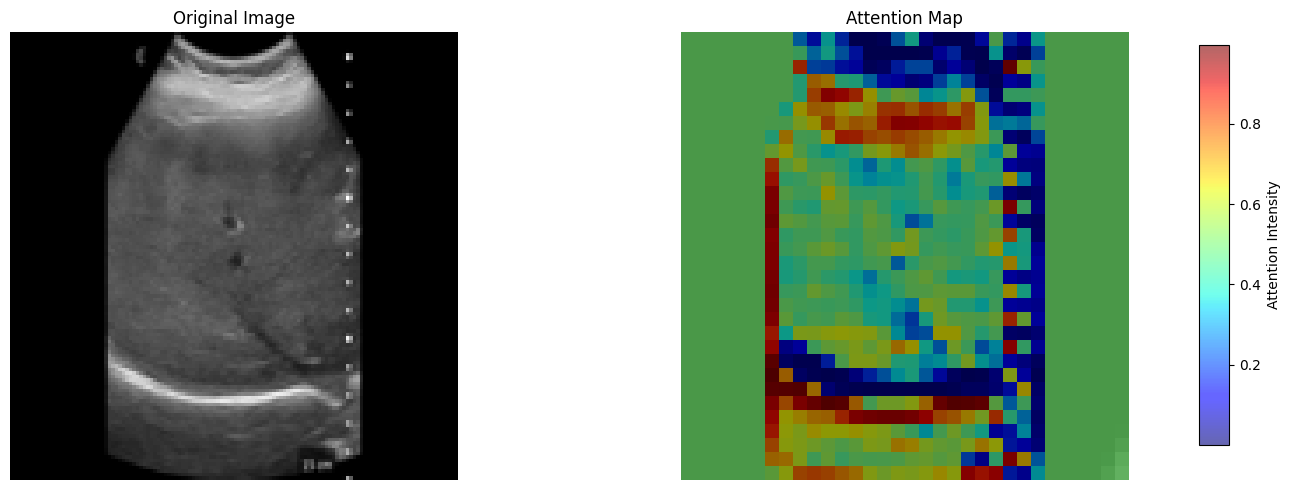

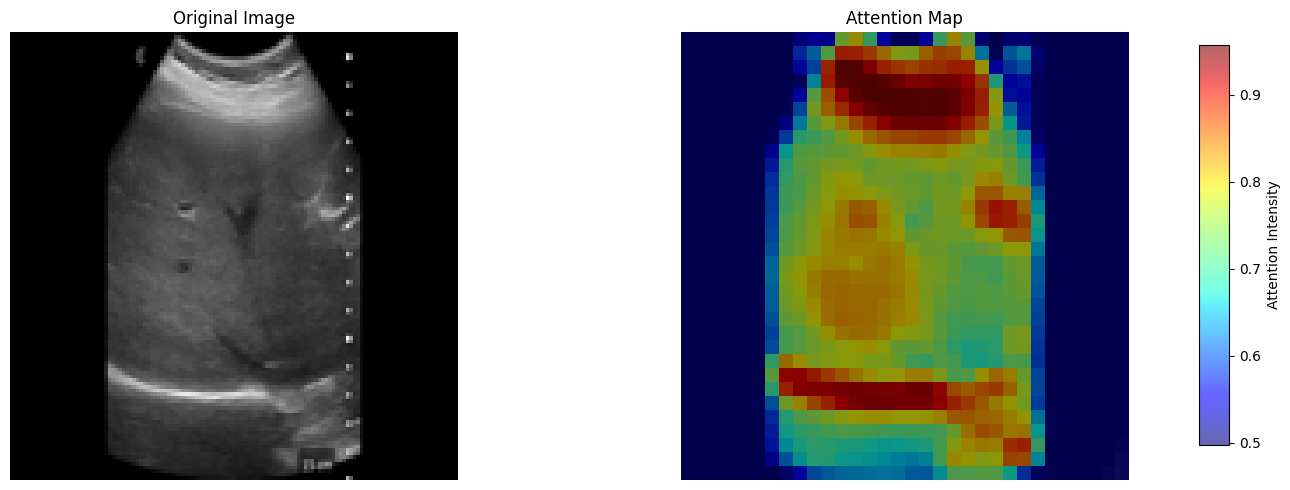

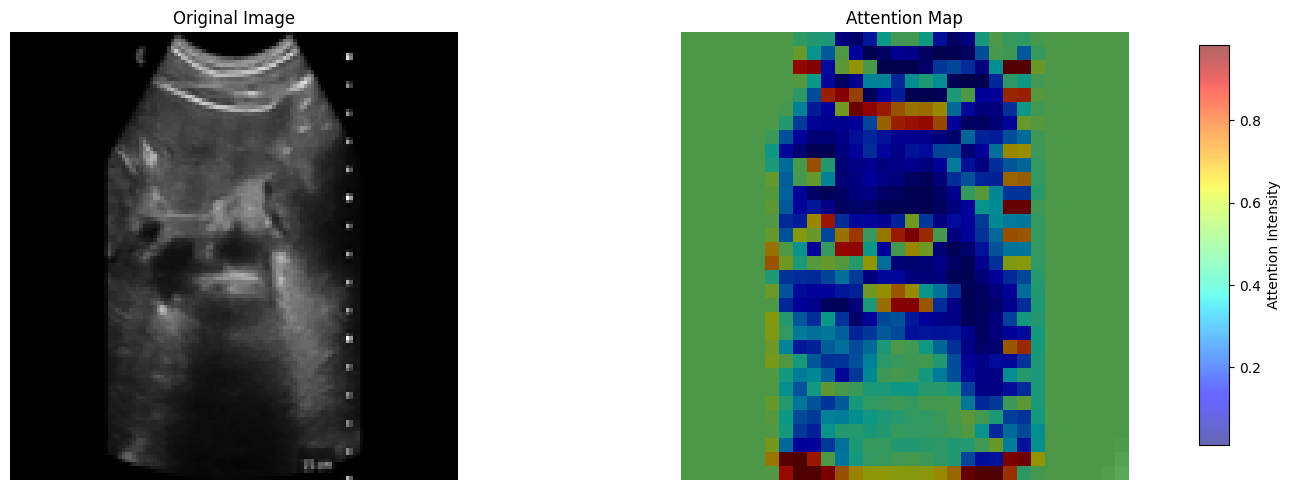

In [ ]:
# visualize attention maps for the first sample of each dataset
visualize_attention_maps_for_sample(attention_maps_o[1], x_test_o[1])
visualize_attention_maps_for_sample(attention_maps_a[1], x_test_a[1])
visualize_attention_maps_for_sample(attention_maps_d[2], x_test_d[2])

# Test Model

In [10]:
def get_test_outputs(x_test, model):
  '''
  Gets the test outputs from the CNN model.

  :@param x_test: Test set images
  :@param model: CNN model
  :@return test_outputs torch vector
  '''
  model.eval() # set model to evaluation mode

  with torch.no_grad():
      test_outputs = model(x_test)

  return test_outputs

def get_metrics(x_test, y_test, model):
  '''
  Collect metrics: accuracy, runtime, peak memory usage, test outputs, y label predictions and f1 score

  :@param x_test: Test set images
  :@param x_test: Test set labels
  :@param model: CNN model
  :@return metrics
  '''
  runtime, peak_mem, test_outputs = get_memory_usage_and_runtime(get_test_outputs, (x_test,model,))

  if isinstance(test_outputs, tuple):
      predictions, attention_weights = test_outputs
  else:
      predictions = test_outputs

  y_pred = torch.argmax(predictions, dim=1).tolist()
  accuracy = torch.sum(torch.tensor(y_pred).to(device) == y_test).item() / len(y_test)

  precision, recall, f1_score, support = precision_recall_fscore_support(y_test.cpu().numpy(), y_pred)
  average_f1_score = np.mean(f1_score)

  return accuracy, runtime, peak_mem, test_outputs, y_pred, average_f1_score

In [ ]:
# Collect all results and display in a dataframe

# Original
model_o = LiverCNN(imgsize=imgsize).to(device)
model_o.load_state_dict(torch.load('cnn_model_original_data.pth'))
accuracy_o, runtime_o, peak_mem_o, test_outputs_o, y_pred_o, f1_o = get_metrics(x_test_o, y_test_o, model_o)

# Original + Augmented
model_a = LiverCNN(imgsize=imgsize).to(device)
model_a.load_state_dict(torch.load('cnn_model_original_plus_augmented_data.pth'))
accuracy_a, runtime_a, peak_mem_a, test_outputs_a, y_pred_a, f1_a = get_metrics(x_test_a, y_test_a, model_a)

# Original + Augmented + External Datasets
model_d = LiverCNN(imgsize=imgsize).to(device)
model_d.load_state_dict(torch.load('cnn_model_original_plus_augmented_plus_external_data.pth'))
accuracy_d, runtime_d, peak_mem_d, test_outputs_d, y_pred_d, f1_d = get_metrics(x_test_d, y_test_d, model_d)

results = {
    "Data": ["Original", "Augmented", "Augmented + External"],
    "Accuracy": [accuracy_o, accuracy_a, accuracy_d],
    "Runtime (1 img)": [runtime_o / test_outputs_o[0].size(0), runtime_a / test_outputs_a[0].size(0), runtime_d / test_outputs_d[0].size(0)],
    "Peak Memory (1 img)": [peak_mem_o / test_outputs_o[0].size(0), peak_mem_a / test_outputs_a[0].size(0), peak_mem_d / test_outputs_d[0].size(0)],
    "Average F1 Score": [f1_o, f1_a, f1_d]
}

results_pd = pd.DataFrame(results)
results_pd

,Data,Accuracy,Runtime (1 img),Peak Memory (1 img),Average F1 Score
0,Original,0.993548,0.000599,3.371242,0.993548
1,Augmented,0.988710,0.001153,3.371402,0.988709
2,Augmented + External,0.965323,0.001129,3.371409,0.965288


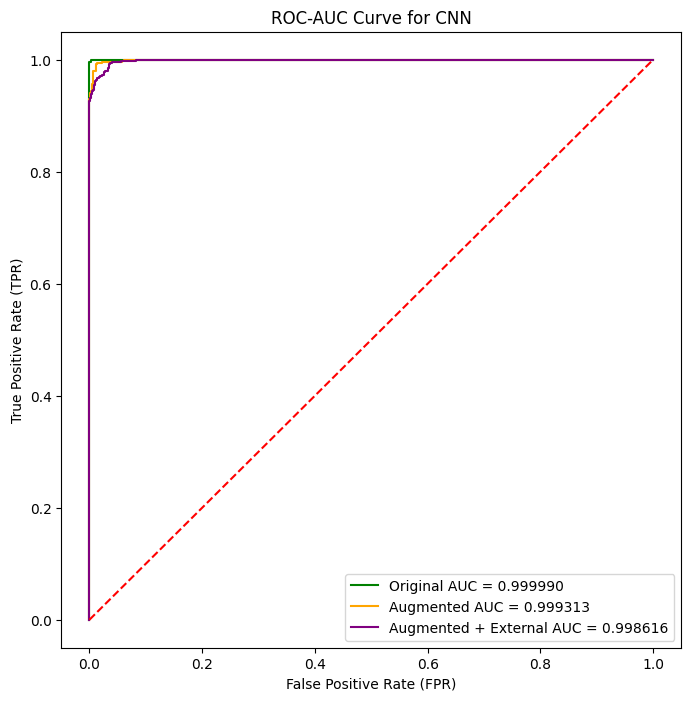

In [ ]:
# Plot ROC-AUC Curve

# get liver probabilities from the test outputs
y_probs_o = torch.nn.functional.softmax(test_outputs_o[0].cpu(), dim=1).detach().numpy()[:, 1]
y_probs_a = torch.nn.functional.softmax(test_outputs_a[0].cpu(), dim=1).detach().numpy()[:, 1]
y_probs_d = torch.nn.functional.softmax(test_outputs_d[0].cpu(), dim=1).detach().numpy()[:, 1]

# plot the curves
y_data = [(y_test_o.cpu().numpy(), y_probs_o, 'green', 'Original'), (y_test_a.cpu().numpy(), y_probs_a, 'orange', 'Augmented'), (y_test_d.cpu().numpy(), y_probs_d, 'purple', 'Augmented + External')]
auc_roc_curves(y_data, "CNN")

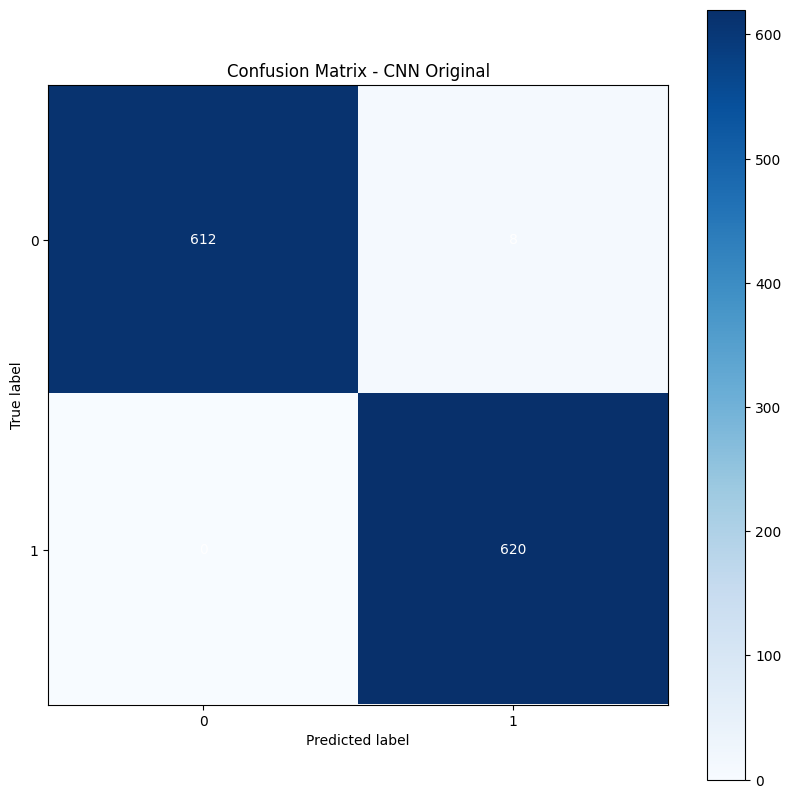

In [ ]:
# Original Confusion Matrix
create_confusion_matrix(y_test_o.cpu().numpy(), y_pred_o, title="- CNN Original")

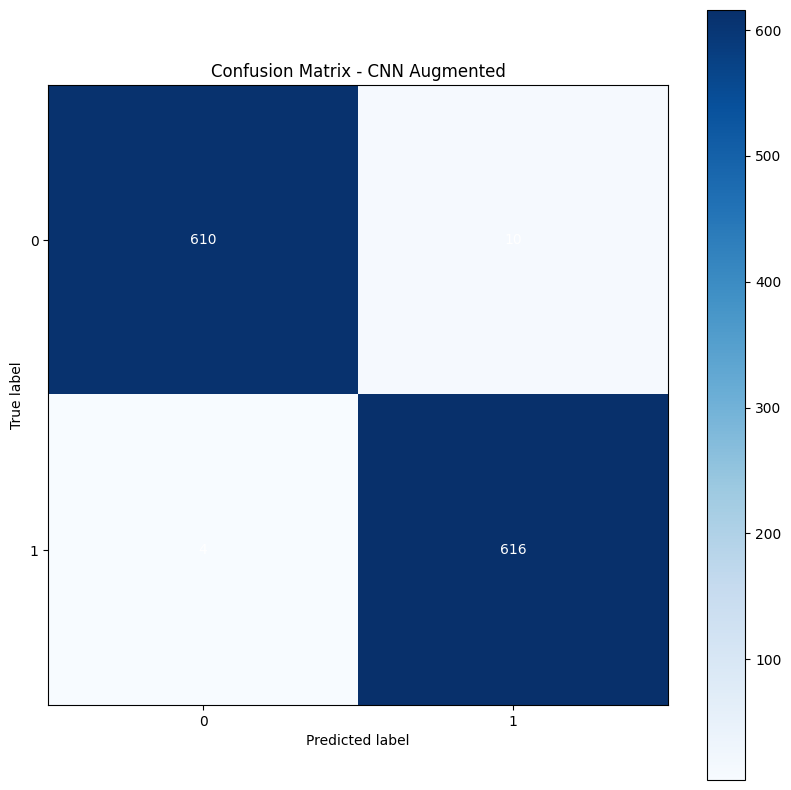

In [ ]:
# Original + Augmented Confusion Matrix
create_confusion_matrix(y_test_a.cpu().numpy(), y_pred_a, title="- CNN Augmented")

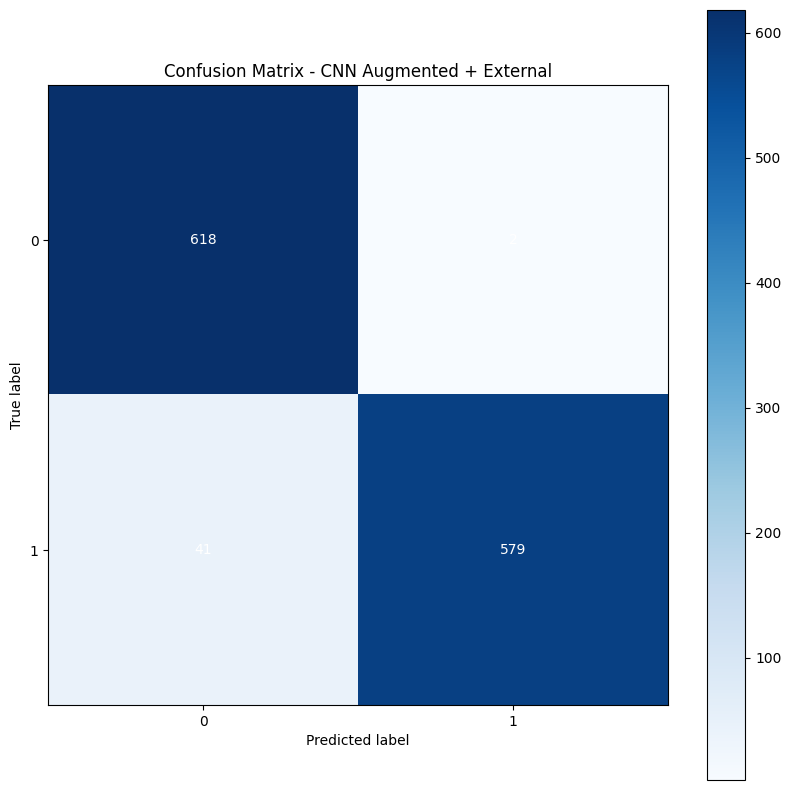

In [ ]:
# Original + Augmented + External Confusion Matrix
create_confusion_matrix(y_test_d.cpu().numpy(), y_pred_d, title="- CNN Augmented + External")